In [3]:
%matplotlib inline
import sys
import json
import os
import collections
import matplotlib.pyplot as plt
from tqdm import tqdm
import importlib
from tqdm import tqdm, tqdm_notebook
sys.path.append('../../examples/weak/notebooks/point_analytics/')
sys.path.append('../../examples/weak/notebooks/')
import point_analytics
import point_analytics.htmldump
import point_analytics.histograms
import point_analytics.response_cleaning
import point_analytics.utils

In [58]:
#Get dictionary for class analysis
with open('id_reference.json', 'r') as f:
    reference = json.load(f)

In [143]:
# Reservoir select from other values
# Used to pad nonuniform-sized batches
import random
def R(it, k):
    '''https://en.wikipedia.org/wiki/Reservoir_sampling#Algorithm_R'''
    it = iter(it)
    result = []
    for i, datum in enumerate(it):
        if i < k:
            result.append(datum)
        else:
            j = random.randint(0, i-1)
            if j < k:
                result[j] = datum
    return result

## 1: Separate into Chunks (discontinued for Part 2)

## Same as Part 1 but separates out s.t. each point is guaranteed to show once

In [83]:
sys.path.append('../../examples/weak/notebooks/')
# import analytics.utils

In [84]:
dirname = '../../examples/weak/notebooks/gt_points/'
name2id = {v['name']: k for k, v in reference.items()}


def copy_over_ground_truth(dirname):
    import shutil
    for fname in os.listdir(dirname):
        if 'formatted' not in fname:
            continue
        shutil.copyfile(os.path.join(dirname, fname),
                        os.path.join('./gt_points/', fname))


def build_gt_dict(dirname):
    D = {}
    for fname in os.listdir(dirname):
        if 'formatted' not in fname:
            continue
        with open(os.path.join('./gt_points', fname), 'r') as f:
            gt_data = json.load(f)
        cls = fname.split('_')[-1].split('.')[0]
        D[cls] = gt_data
    return D


def switch_xy(gt_data):
    for obj_class, data in gt_data.items():
        for p_data in data:
            for imid, imid_data in p_data.items():
                for key, payload in imid_data['points']['data'].items():
                    points = payload['points'][0]
                    payload['points'] = [[points[1], points[0]]]

def pop_out_examples(gt_data):
    examples = {}
    bla = {}
    for obj_class, data in gt_data.items():
        need_whole_example = True
        need_part_example = True
        examples[obj_class] = {}
        real_data = []
        for i, p_data in enumerate(data):
            ID = p_data.values()[0]['gt']
            if(need_whole_example and ID == '100'):
                examples[obj_class]['obj'] = p_data
                need_whole_example = False
            elif (need_part_example and ID != '100'):
                examples[obj_class]['part'] = p_data
                need_part_example = False
            else:
                real_data.append(p_data)
        bla[obj_class] = real_data
    return examples, bla
def segment_by_obj_part(gt_data):
    copied = {}
    for obj_class, data in gt_data.items():
        segmented = {'obj': [], 'part': []}
        for i, p_data in enumerate(data):
            ID = p_data.values()[0]['gt']
            if(ID == '100'):
                segmented['obj'].append(p_data)
            else:
                segmented['part'].append(p_data)
        copied[obj_class] = segmented
    return copied

### Load gold standards

In [6]:
# copy_over_ground_truth(dirname)

In [141]:
gt_data = build_gt_dict(dirname)
switch_xy(gt_data)
gt_data = {name2id[k] : v for k, v in gt_data.items()}
examples, gt_data = pop_out_examples(gt_data)
gt_data = segment_by_obj_part(gt_data)

In [8]:
# with open('clswise_examples.json', 'w+') as f:
#     json.dump(examples, f)
#!mv clswise_examples.json ../../examples/weak/notebooks/gt_points/

### Below, do the actual manipulations. Skip to section 3 if you wish to simply update existing data.

In [10]:
# full_names = 'points/valid_ims_double.json' #Before using medial axis skeletons for the silhouette class
# full_data = 'points/valid_points_double.json'
# full_names = 'points/valid_ims_medial.json'
# full_data = 'points/valid_points_meds.json'
# full_names = 'points/valid_ims_medial_centered.json'
# full_data = 'points/valid_points_meds_centered.json'
# full_names = 'points/valid_ims_medial_centered_all.json'
# full_data = 'points/valid_points_meds_centered_all.json'
full_names = 'points/keys_2018_02_11_all_points_full_silhouettes.json'
full_data = 'points/data_2018_02_11_all_points_full_silhouettes.json'

In [54]:
with open(full_names, 'r') as f:
     names = json.load(f)
with open(full_data, 'r') as f:
     data = json.load(f)

* Convert data to list of [{imid: singular_datum}, ...] format
* Segment list by object type
* Shuffle to reduce likelihood of getting repeat images

In [59]:
#Assign a list of image names to each object type
obj2images = collections.defaultdict(list)
for name in names:
    types = data[name]['points']['data'].keys()
    containedObjects = set()
    components = collections.defaultdict(list)
    for t in types:
        obj = t.split('_')[0]
        components[obj].append(t)
        containedObjects.add(obj)
    for obj in containedObjects:
        obj2images[obj].append(name)    

In [61]:
image2obj = collections.defaultdict(list)
for k, l in obj2images.items():
    for v in l:
        image2obj[v].append(k)

### Flatten the points into a {cls: [question , ...]} dict

In [60]:
# Convert the data dictionary (specified) to
def legally_flatten_data(data, num_classes=15):
    seen = {}
    i = 0
    flattened = []
    errors = []
    for im_name, pd in data.items():
        im_addr = pd['im']
        size = pd['points']['size']
        if isinstance(pd['points']['data'], type(None)):
            errors.append(im_name)
            continue
        for point_id, point_data in pd['points']['data'].items():
            #             print point_id, point_data
            area = point_data['area']
            points = point_data['points']
            cls = point_id.split('_')[0]
            for point in points:
                payload = {im_name: {'im': im_addr,
                                     'points': {
                                         'data': {point_id: {
                                             'area': area,
                                             'points': [point]
                                         }},
                                         'size': size
                                     }
                                     }
                           }
                if cls not in seen:
                    flattened.append([payload])
                    seen[cls] = i
                    i += 1
                else:
                    flattened[seen[cls]].append(payload)
    return flattened, errors

In [62]:
flt_seg_data, errors = legally_flatten_data(data)

In [ ]:
it = 0
for cls_data in flt_seg_data:
    for HIT in cls_data:
        it+=1
print(it)

### Make the batches

In [ ]:
# Given a batch_size, arrange into HITs
from random import shuffle
batch_size = 50  # Size of each HIT
num_gt = 6
max_chunks = np.infty
# Ensure that we have exactly num_gt number of golden standards
batch_size = batch_size-num_gt
batched_data = []
gt_data_index = {}

for cls, points in gt_data.items():
    gt_data_index[cls] = {}
    gt_data_index[cls]['obj'] = 0
    gt_data_index[cls]['part'] = 0

for obj_list in flt_seg_data:
    obj_class = list(list(obj_list[0].values())[
                     0]['points']['data'])[0].split('_')[0]
    rand_list = obj_list
    shuffle(rand_list)
    N = len(rand_list)
    chunked = [rand_list[i:min(i+batch_size, N)]
               for i in range(0, N, batch_size)]
    M = len(chunked)
    for i, chunk in enumerate(chunked):
        if len(chunk) != batch_size:  # randomly add elements from another chunk to pad to full size
            toadd = batch_size - len(chunk)
            toappend = R(rand_list, toadd)
            chunk.extend(toappend)
        if len(chunk) != batch_size:  # Error padding
            raise RuntimeError("{} not correct size.".format(len(chunk)))

        # Add gold standards from object class
        index = gt_data_index[obj_class]['obj']
        gold_standards = gt_data[obj_class]['obj']
        next_ind = (index+num_gt//2) % len(gold_standards)
        gt_data_index[obj_class]['obj'] = next_ind
        if next_ind < index:
            gold_to_append = gold_standards[index:len(gold_standards)]
            gold_to_append.extend(gold_standards[0:next_ind])
        else:
            gold_to_append = gold_standards[index:next_ind]
        chunk.extend(gold_to_append)
#         batched_data.append(chunk)

        # Add gold standards from part class
        index = gt_data_index[obj_class]['part']
        gold_standards = gt_data[obj_class]['part']
        next_ind = (index+num_gt//2) % len(gold_standards)
        gt_data_index[obj_class]['part'] = next_ind
        if next_ind < index:
            gold_to_append = gold_standards[index:len(gold_standards)]
            gold_to_append.extend(gold_standards[0:next_ind])
        else:
            gold_to_append = gold_standards[index:next_ind]
        chunk.extend(gold_to_append)
        batched_data.append(chunk)
        if i > max_chunks:
            break

#### Write to file

In [ ]:
with open('clswise_with_gt.json', 'w+') as f:
    for line in batched_data:
        f.write('{}\n'.format(json.dumps(line)))

In [ ]:
# Separate into files by class

### Get classwise Chunks

In [ ]:
bycls = collections.defaultdict(list)
for i, l in enumerate(batched_data):
    cls=l[0].values()[0]['points']['data'].keys()[0].split('_')[0]
    bycls[cls].append(l)

#### Write to file

In [ ]:
for k, v in bycls.items():
    name = reference[k]['name']
    with open('BYCLASS/gt_BYNAME_'+name+'_centered.json', 'w+') as f:
        for line in v:
            f.write('{}\n'.format(json.dumps(line)))

# Modifying existing Data
## Part 1: Updating info for occluded points.

In [87]:
# Get masks
import sys
sys.path.append('../../../../detail-api-3.0.0/PythonAPI/')
from detail import Detail
annFile = '../../../../JSON/trainval_parts.json'  # annotations
details = Detail(annFile)

loading annotations into memory...
Done (t=2.78s)
creating index...
index created!


In [86]:
def drawPoint(im, y, x):
    from PIL import Image, ImageDraw
    if not isinstance(im, Image.Image):
        im = Image.fromarray(im.astype(np.uint8))
    cp = im.copy()
    draw = ImageDraw.Draw(cp)
    draw.ellipse((x - 8, y - 8, x + 8, y + 8), fill='red', outline='blue')
    draw.ellipse((x - 3, y - 3, x + 3, y + 3), fill='green', outline='blue')
    # draw.point((x, y), 'red')
    return cp


def check_occluded(imid, point, cls, inst=None, details=None):
    ''' Check whether a point (x,y) of class "cls" and instance id "inst" is in the background
        (e.g. if another Pascal object supersedes that region).
        The (hacky) logic relies on the accuracy of the semantic segmenation (which performs 
        layering of overlapping instances). If the point is labelled as the class "cls" in the
        semantic image segmentation, we accept the object as being not occluded by another
        Pascal object.
        "details" is a Details object.
    '''
    if isinstance(imid, str) or isinstance(imid, basestring):
        imid = int(imid[:4]+imid[5:])
#     ann = details.getAnns(imgs=imid)
    # Check whether point is occluded by a different class
    semantic_mask = details.getMask(img=imid)  # Get semantic segmentation mask
    x, y = int(point[1]), int(point[0])
    gt_class = int(semantic_mask[y, x])
    if gt_class != int(cls):
        #         print(int(semantic_mask[y,x]), int(cls))
        if gt_class == 0:
#             print("ERROR")
#             print(imid)
#             mask = (semantic_mask == int(cls)).astype(np.uint8) * 255
#             mask = drawPoint(mask, y, x)
#             plt.imshow(mask)
#             plt.show()
            return False, (imid, point, cls)
        return True, gt_class  # Is occluded

    # TODO
    # Check whether point is occluded by a different instance
    # TODO
    # Check whether poin tis occluded by a different PART
    return False, 0


def update_occluded(question, details, new_cls=None):
    '''Update a point which has previously been found to be occluded.
       Question (an entry for a HIT) will be updated by reference, 
       selecting the correct instance and part on which the point lands.
       updated question will then have the object class "cls".
       cls is used
    '''
    import copy
    imid_ = question.keys()[0]  # numeric version used for details api
    imid = imid_
    if isinstance(imid_, str) or isinstance(imid_, basestring):
        imid_ = int(imid_[:4]+imid_[5:])
    # Make useable
    cls_inst_part = list(question[imid]['points']['data'].keys())[0]
    point = question[imid]['points']['data'][cls_inst_part]['points'][0]

    if isinstance(new_cls, type(None)):
        cls = cls_inst_part.split("_")[0]
        is_occluded, new_cls = check_occluded(imid_, point, cls, None, details)
        if not is_occluded:
            return False, new_cls

    # Get new instance
    # Get instance segmentation mask
    instance_mask = details.getMask(img=imid_, cat=new_cls)
    x, y = int(point[1]), int(point[0])
    new_inst = int(instance_mask[y, x])
    # Get new part
    part_mask = details.getMask(
        img=imid_, cat=new_cls, instance=new_inst)  # Get part mask
    new_part = int(part_mask[y, x])
    part_area = (part_mask == new_part).sum()

#     print(new_cls, new_inst, new_part)
    q_up = copy.deepcopy(question)
    dat = q_up.values()[0]['points']['data']
    q_up.values()[0]['points']['data'] = {str(new_cls) + "_" + str(new_inst) + "_" + str(new_part):
                                {'area': part_area,
                                 'points': dat.values()[0]['points']}
                                }
    return True, q_up


def question2key(question):
    imid = list(question.keys())[0].strip()
    cls_inst_part = list(question[imid]['points']['data'].keys())[0]
    points = question[imid]['points']['data'][cls_inst_part]['points']
    x, y = str(points[0][0]), str(points[0][1])
    return imid + "_" + cls_inst_part + "_" + x + "_" + y

In [102]:
clswise_with_gt = []
# fname = 'clswise_with_gt.json'
fname = 'thresholded_clswise_with_gt.json'
with open(fname, 'r') as f:
    for line in f.readlines():
        clswise_with_gt.append(json.loads(line.strip()))

In [89]:
from tqdm import tqdm_notebook, tnrange

In [103]:
keys_to_update = {}
with open('cache/seen.json', 'r') as f:
    seen = set(json.load(f))
try:
    with open('cache/keys_to_update.json', 'r') as f:
        keys_to_update = json.load(f)
except:
    print("not good")
errors = []
for i, hit in tqdm_notebook(enumerate(clswise_with_gt), total=len(clswise_with_gt)):
    for j, question in enumerate(hit):
        key = question2key(question)
        if key in seen:
            continue
        seen.add(key)
        updated, q_up = update_occluded(question, details)
        if updated:
            keys_to_update[key] = q_up
        else:
            if isinstance(q_up, tuple):
                errors.append(q_up)
with open('cache/seen.json', 'w+') as f:
    json.dump(list(seen), f)
with open('cache/keys_to_update.json', 'w+') as f:
    json.dump(keys_to_update, f)

HBox(children=(IntProgress(value=0, max=6142), HTML(value=u'')))

#### Directly replace (deprecated. Must have class specific...)

In [ ]:
# for fname in os.listdir('BYCLASS/archived'):
#     if 'gt_BYNAME' not in fname:
#         continue
#     point_data = []
#     read_name = os.path.join('BYCLASS','archived', fname)
#     write_name = os.path.join('BYCLASS', fname)
#     with open(read_name, 'r') as f:
#         for line in f.readlines():
#             point_data.append(json.loads(line.strip()))
#     for i, hit in tqdm(enumerate(point_data)):
#         for j, question in enumerate(hit):
#             key = question2key(question)
#             if key not in keys_to_update:
#                 continue
#             q_update = keys_to_update[key]
#             point_data[i][j] = q_update
#     with open(write_name, 'w+') as f:
#         for hit in point_data:
#             f.write("{}\n".format(json.dumps(hit)))        

### Replace occluded points with other points of the correct class

Order of precidence: 
1. Points which were newly added (from othe occluded points)
2. Randomly from larger reservoir

In [104]:
def get_random_question(cls, obj2fixed_points, obj2random_points, used):
    try:
        key, data = obj2fixed_points[cls].popitem()
        return data
    except KeyError:
        try:
            key, data = obj2random_points[cls].popitem()
            return data
        except KeyError:
            raise RuntimeError("Not enough unsed items")

In [12]:
# Store the updated questions by object class
point_data = clswise_with_gt
obj2fixed_points = collections.defaultdict(dict)
for k, qup in keys_to_update.items():
    obj = k.split("_")[2]
    new_obj = list(list(qup.values())[0]['points']['data'].keys())[
        0].split("_")[0]
    obj2fixed_points[new_obj][k] = qup
obj2random_points = collections.defaultdict(dict)
for i, hit in tqdm_notebook(enumerate(point_data), total=len(point_data)):
    for j, question in enumerate(hit):
        key = question2key(question)
        obj = key.split("_")[2]
        if key not in keys_to_update:
            obj2random_points[obj][key] = question

HBox(children=(IntProgress(value=0, max=7906), HTML(value=u'')))

In [ ]:
# This doesn't care about classes since it is all jumbled
read_name = 'archived/clswise_with_gt.json'
write_name = 'clswise_with_gt.json'
point_data = []
print("Reading {}".format(read_name))
with open(read_name, 'r') as f:
    for line in tqdm_notebook(f.readlines()):
        point_data.append(json.loads(line.strip()))
for i, hit in tqdm_notebook(enumerate(point_data), total=len(point_data)):
    for j, question in enumerate(hit):
        key = question2key(question)
        if key not in keys_to_update:
            continue
        q_update = keys_to_update[key]
        point_data[i][j] = q_update
with open(write_name, 'w+') as f:
    for hit in point_data:
        f.write("{}\n".format(json.dumps(hit)))        

In [14]:
used = set()
import copy
print("Copying items")
obj2fp = tqdm_notebook(copy.deepcopy(obj2fixed_points))
obj2rp = tqdm_notebook(copy.deepcopy(obj2random_points))
print("Done")
for fname in os.listdir('BYCLASS/archived'):
    if 'gt_BYNAME' not in fname:
        continue
    point_data = []
    read_name = os.path.join('BYCLASS','archived', fname)
    tqdm.write(read_name)
    write_name = os.path.join('BYCLASS', fname)
    with open(read_name, 'r') as f:
        for line in f.readlines():
            point_data.append(json.loads(line.strip()))
    class_key = question2key(point_data[0][0])
    this_class = class_key.split("_")[2]
    
    for i, hit in tqdm_notebook(enumerate(point_data), total=len(point_data)):
        for j, question in enumerate(hit):
            key = question2key(question)
            if key not in keys_to_update:
                continue
#             q_update = keys_to_update[key]
#             cls = list(list(q_update.values())[0]['points']['data'].keys())[0].split("_")[0]
#             cls = key.split("_")[2]
            q_update = get_random_question(this_class, obj2fp, obj2rp, used)
            if question2key(q_update).split("_")[2] != this_class:
                raise RuntimeError("{} != {}".format(this_class, question2key(q_update).split("_")[2]))
            point_data[i][j] = q_update
            
    with open(write_name, 'w+') as f:
        for hit in point_data:
            f.write("{}\n".format(json.dumps(hit)))        

Copying items


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=20), HTML(value=u'')))

Done
BYCLASS/archived/gt_BYNAME_person_centered.json


HBox(children=(IntProgress(value=0, max=4206), HTML(value=u'')))

BYCLASS/archived/gt_BYNAME_bus_centered.json


HBox(children=(IntProgress(value=0, max=240), HTML(value=u'')))

BYCLASS/archived/gt_BYNAME_car_centered.json


HBox(children=(IntProgress(value=0, max=514), HTML(value=u'')))

BYCLASS/archived/gt_BYNAME_dog_centered.json


HBox(children=(IntProgress(value=0, max=706), HTML(value=u'')))

BYCLASS/archived/gt_BYNAME_horse_centered.json


HBox(children=(IntProgress(value=0, max=347), HTML(value=u'')))

BYCLASS/archived/gt_BYNAME_pottedplant_centered.json


HBox(children=(IntProgress(value=0, max=72), HTML(value=u'')))

BYCLASS/archived/gt_BYNAME_cow_centered.json


HBox(children=(IntProgress(value=0, max=181), HTML(value=u'')))

BYCLASS/archived/gt_BYNAME_cat_centered.json


HBox(children=(IntProgress(value=0, max=537), HTML(value=u'')))

BYCLASS/archived/gt_BYNAME_aeroplane_centered.json


HBox(children=(IntProgress(value=0, max=187), HTML(value=u'')))

BYCLASS/archived/gt_BYNAME_train_centered.json


HBox(children=(IntProgress(value=0, max=121), HTML(value=u'')))

BYCLASS/archived/gt_BYNAME_motorbike_centered.json


HBox(children=(IntProgress(value=0, max=59), HTML(value=u'')))

BYCLASS/archived/gt_BYNAME_bottle_centered.json


HBox(children=(IntProgress(value=0, max=86), HTML(value=u'')))

BYCLASS/archived/gt_BYNAME_sheep_centered.json


HBox(children=(IntProgress(value=0, max=253), HTML(value=u'')))

BYCLASS/archived/gt_BYNAME_bicycle_centered.json


HBox(children=(IntProgress(value=0, max=112), HTML(value=u'')))

BYCLASS/archived/gt_BYNAME_bird_centered.json


HBox(children=(IntProgress(value=0, max=285), HTML(value=u'')))

## Remove points close to the border

* Simply delete all points which lie within threshold distance of the image border

In [9]:
def separate_key(key):
    vals = key.rsplit("_", 5)
    return {
        'imid': vals[0],
        'obj_id': vals[1],
        'inst_id': vals[2],
        'part_id': vals[3],
        'xCoord': vals[4],
        'yCoord': vals[5]}


def get_im_from_s3(imid):
    from skimage import io
    if isinstance(imid, int):
        imid = str(imid)[:4] + "_" + str(imid)[4:]
    prefix = 'https://s3.amazonaws.com/visualaipascalparts/'
    suffix = '.jpg'
    uri = prefix + imid + suffix
    img = io.imread(uri)
    img = Image.fromarray(img)
    return img

In [16]:
# This doesn't care about classes since it is all jumbled
read_name = 'clswise_with_gt.json'
write_name = read_name
point_data = []
print("Reading {}".format(point_data))
with open(read_name, 'r') as f:
    for line in tqdm_notebook(f.readlines()):
        point_data.append(json.loads(line.strip()))

Reading []


HBox(children=(IntProgress(value=0, max=7906), HTML(value=u'')))

### Find all invalid points
#### Could start from here if you wish to redo the dataset

In [115]:
point_data = []
with open('thresholded_clswise_with_gt.json', 'r') as f:
    for l in tqdm_notebook(f):
        point_data.append(json.loads(l.strip()))
    

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

In [116]:
keys_on_border = set()
with open('cache/keys_on_border.json', 'r') as f:
    threshold = int(f.readline().strip())
    keys_on_border = set(json.load(f))
num_on_border = 0.0
total = 0.0
# threshold = 10  # Minimum number of pixels away from border a point must be to be valid
for i, hit in tqdm_notebook(enumerate(point_data), total=len(point_data)):
    for j, question in enumerate(hit):
        key = question2key(question)
        keydat = separate_key(key)
        x,y = int(keydat['xCoord']), int(keydat['yCoord'])
        imid = int("".join(keydat['imid'].split("_")))
        img = details.getImgs(imgs=imid)[0]
        w,h = int(img['width']), int(img['height'])
#         img = get_im_from_s3(keydat['imid'])
#         w,h = img.size
        if x < threshold or x > w-threshold:
#             print(w,h,x,y)
            keys_on_border.add(key)
            num_on_border+=1
        elif y < threshold or y > h - threshold:
#             print(w,h,x,y)
            keys_on_border.add(key)
            num_on_border+=1
        total+=1
print("{} keys or {:0.2f}\% of dataset lie on border.".format(num_on_border, (num_on_border/total)*100))
print("Caching keys_on_border")
with open('cache/keys_on_border.json', 'w+') as f:
    f.write("{}\n".format(threshold))
    json.dump(list(keys_on_border), f)


HBox(children=(IntProgress(value=0, max=6142), HTML(value=u'')))


7382.0 keys or 2.40\% of dataset lie on border.
Caching keys_on_border


### Flatten point_data  to only include unique, legal keys

#### Find all gt points to remove from the stew

In [117]:
gt_keys = set()
for i, hit in tqdm_notebook(enumerate(point_data), total=len(point_data)):
    for j, question in enumerate(hit):
        key = question2key(question)
        if 'gt' in question.values()[0]:
            gt_keys.add(key)
print(len(gt_keys))

HBox(children=(IntProgress(value=0, max=6142), HTML(value=u'')))


2177


#### Remove all gt and thresholded points

In [119]:
point_data_flattened_unique = []
data_by_cls = collections.defaultdict(list)
for i, hit in tqdm_notebook(enumerate(point_data), total=len(point_data)):
    for j, question in enumerate(hit):
        key = question2key(question)
        keydat = separate_key(key)
        cls = int(keydat['obj_id'])
        if key in keys_on_border or key in gt_keys:
            continue
        data_by_cls[cls].append(question)

HBox(children=(IntProgress(value=0, max=6142), HTML(value=u'')))

In [129]:
flt_seg_data_interior = [v for v in data_by_cls.values()]
print("{} remaining annotations".format(np.array([len(v) for v in flt_seg_data_interior]).sum()))

270248 remaining annotations


#### Remove points already annotated

In [130]:
with open('cache/annotated_keys.json', 'r') as f:
    already_annotated = set(json.load(f))

In [136]:
for i, obj in enumerate(flt_seg_data_interior):
    questions = []
    for question in obj:
        if question2key(question) in already_annotated:
            continue
        questions.append(question)
    flt_seg_data_interior[i] = questions
print("{} remaining annotations".format(np.array([len(v) for v in flt_seg_data_interior]).sum()))

270236 remaining annotations


In [139]:
def get_batched_data(gt_data, flt_seg_data=flt_seg_data_interior):
    # Given a batch_size, arrange into HITs
    from random import shuffle
    batch_size = 50  # Size of each HIT
    num_gt = 6
    max_chunks = np.infty
    # Ensure that we have exactly num_gt number of golden standards
    batch_size = batch_size-num_gt
    batched_data = []
    gt_data_index = {}

    for cls, points in gt_data.items():
        gt_data_index[cls] = {}
        gt_data_index[cls]['obj'] = 0
        gt_data_index[cls]['part'] = 0

    for obj_list in flt_seg_data:
        obj_class = list(list(obj_list[0].values())[
                         0]['points']['data'])[0].split('_')[0]
        rand_list = obj_list
        shuffle(rand_list)
        N = len(rand_list)
        chunked = [rand_list[i:min(i+batch_size, N)]
                   for i in range(0, N, batch_size)]
        M = len(chunked)
        for i, chunk in enumerate(chunked):
            if len(chunk) != batch_size:  # randomly add elements from another chunk to pad to full size
                toadd = batch_size - len(chunk)
                toappend = R(rand_list, toadd)
                chunk.extend(toappend)
            if len(chunk) != batch_size:  # Error padding
                raise RuntimeError("{} not correct size.".format(len(chunk)))

            # Add gold standards from object class
            index = gt_data_index[obj_class]['obj']
            gold_standards = gt_data[obj_class]['obj']
            next_ind = (index+num_gt//2) % len(gold_standards)
            gt_data_index[obj_class]['obj'] = next_ind
            if next_ind < index:
                gold_to_append = gold_standards[index:len(gold_standards)]
                gold_to_append.extend(gold_standards[0:next_ind])
            else:
                gold_to_append = gold_standards[index:next_ind]
            chunk.extend(gold_to_append)
    #         batched_data.append(chunk)

            # Add gold standards from part class
            index = gt_data_index[obj_class]['part']
            gold_standards = gt_data[obj_class]['part']
            next_ind = (index+num_gt//2) % len(gold_standards)
            gt_data_index[obj_class]['part'] = next_ind
            if next_ind < index:
                gold_to_append = gold_standards[index:len(gold_standards)]
                gold_to_append.extend(gold_standards[0:next_ind])
            else:
                gold_to_append = gold_standards[index:next_ind]
            chunk.extend(gold_to_append)
            batched_data.append(chunk)
            if i > max_chunks:
                break
    return batched_data

In [144]:
batched_data = get_batched_data(gt_data, flt_seg_data_interior)

In [145]:
with open('thresholded_clswise_with_gt.json', 'w+') as f:
    for line in batched_data:
        f.write('{}\n'.format(json.dumps(line)))

In [30]:
# Separate into files by class

### Get classwise Chunks

In [146]:
bycls = collections.defaultdict(list)
for i, l in enumerate(batched_data):
    cls=l[0].values()[0]['points']['data'].keys()[0].split('_')[0]
    bycls[cls].append(l)

#### Write to file

In [147]:
for k, v in bycls.items():
    name = reference[k]['name']
    with open('BYCLASS/thresholded_gt_BYNAME_'+name+'_centered.json', 'w+') as f:
        for line in v:
            f.write('{}\n'.format(json.dumps(line)))

#### Translate dog left eye from 113->190

In [24]:
all_data = []
with open('BYCLASS/thresholded_gt_BYNAME_dog_centered.json', 'r') as f:
    for line in f:
        all_data.append(json.loads(line.strip()))

In [26]:
# Disambiguoate the dog's right ear (113) from the dog itself (also 113)
for i, hit in enumerate(all_data):
    for j, question in enumerate(hit):
        key = list(list(question.values())[0]['points']['data'].keys())[0]
        data = list(question.values())[0]['points']['data'][key]
        keysplt = key.split("_")
        if keysplt[0] == '113' and keysplt[2] == '113':
            print(key)
            keysplt[2] = '190'
            newkey = "_".join(keysplt)
            list(question.values())[0]['points']['data'] = {newkey: data}

In [27]:
with open('BYCLASS/thresholded_gt_BYNAME_dog_centered.json', 'w') as f:
    for hit in all_data:
        f.write("{}\n".format(json.dumps(hit)))    

# Analyze distributions

In [70]:
def _make_dict_hr(D, ref):
    parts = set(list(ref.keys()))
    for k, v in D.items():
        if str(k) in parts:
            D[ref[str(k)]] = D.pop(k)
        if isinstance(v, dict):
            _make_dict_hr(v, ref)
def make_dict_hr(D, ref):
    objects = set(list(ref.keys()))
    for k, v in D.items():
        if str(k) in objects:
            D[ref[str(k)]['name']] = D.pop(k, None)
        if isinstance(v, dict):
            _make_dict_hr(v, ref[k]['parts'])
       

In [ ]:
all_data = []
with open('thresholded_clswise_with_gt.json', 'r') as f:
    for line in f:
        all_data.append(json.loads(line.strip()))

In [ ]:
# Disambiguoate the dog's left eye (113) from the dog itself (also 113)
for i, hit in enumerate(all_data):
    for j, question in enumerate(hit):
        key = list(list(question.values())[0]['points']['data'].keys())[0]
        data = list(question.values())[0]['points']['data'][key]
        keysplt = key.split("_")
        if keysplt[0] == '113' and keysplt[2] == '113':
            print(key)
            keysplt[2] = '190'
            newkey = "_".join(keysplt)
            list(question.values())[0]['points']['data'] = {newkey: data}

In [19]:
with open('thresholded_clswise_with_gt.json', 'w') as f:
    for hit in all_data:
        f.write("{}\n".format(json.dumps(hit)))    

In [77]:
dump_to_html = True
stats = {}
for hit in all_data:
    for question in hit:
        key = question2key(question)
        keydat = separate_key(key)
        obj = keydat['obj_id']
        part = keydat['part_id']
        if obj not in stats:
            stats[obj] = {'object': 0, 'part': 0,
                          'parts': collections.defaultdict(int)}
        if part == '100':
            stats[obj]['object'] += 1
        else:
            stats[obj]['part'] += 1
            stats[obj]['parts'][part] += 1
for obj in stats:
    stats[obj]['parts'] = dict(stats[obj]['parts'])
freq_stats = histograms.normalize_general_histogram(stats)
make_dict_hr(freq_stats, reference)

In [78]:
for k in freq_stats:
    freq_stats[k][k+'_parts'] = freq_stats[k].pop('parts', None)

writing to web


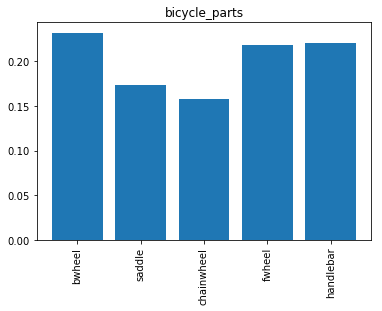

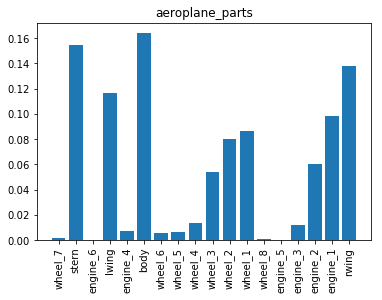

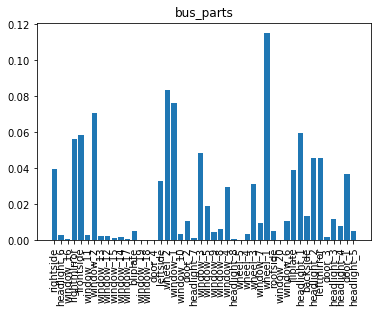

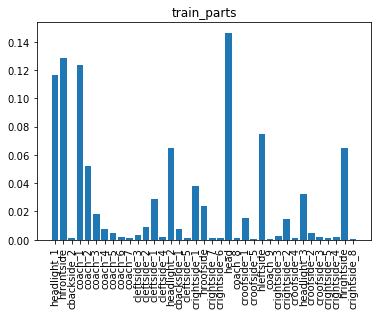

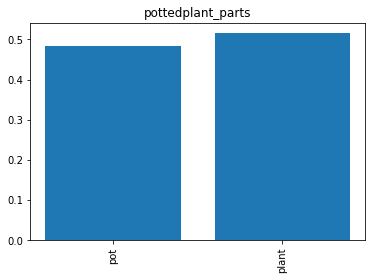

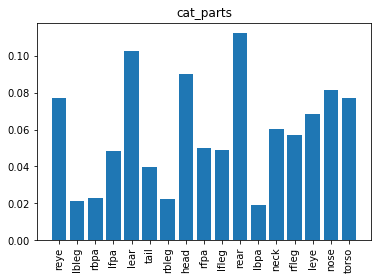

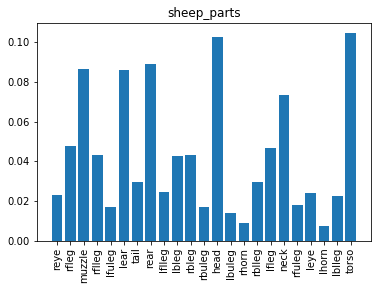

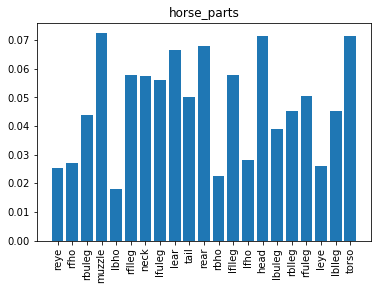

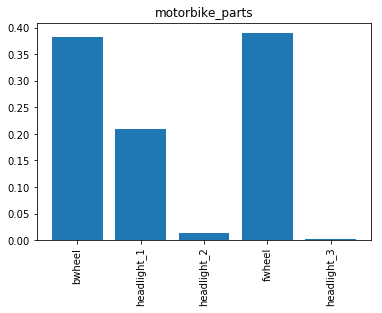

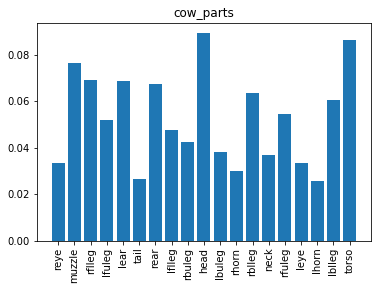

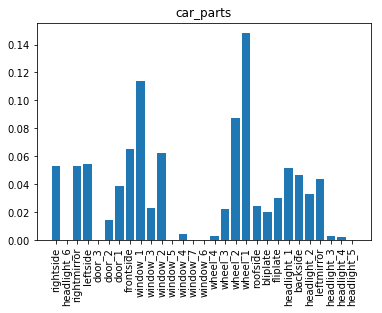

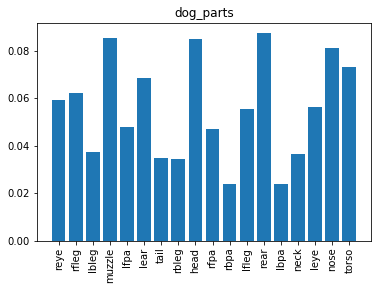

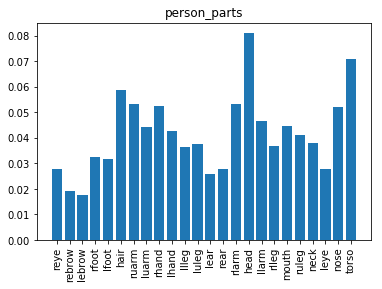

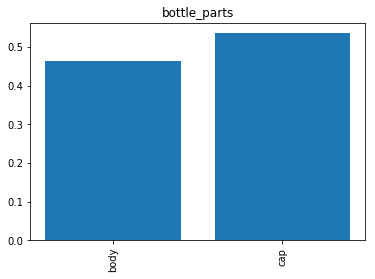

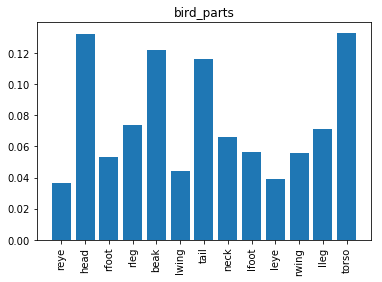

In [81]:
reload(point_analytics.histograms)
if dump_to_html:
    plots = point_analytics.histograms.plot_histograms('hm', freq_stats)
    plots = [("", "", img) for img in plots]
    page_data = point_analytics.htmldump.create_html_file(plots, "Distributions")
    with open('web/distributions.html', 'w+') as f:
        print('writing to web')
        f.write(page_data)